In [2]:

# Mount Google Drive to access dataset files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


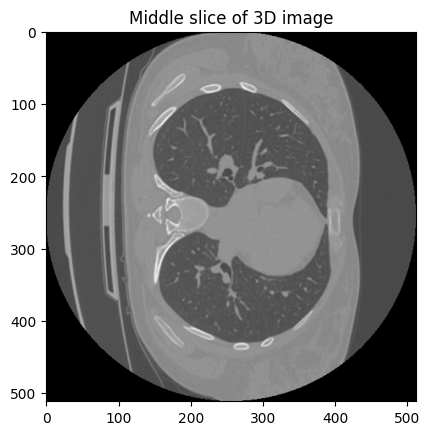

In [3]:
import os
import nibabel as nib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import zoom  # For 3D resizing
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras_tuner import HyperModel, RandomSearch

def load_nii_image(image_path):
    img = nib.load(image_path)
    img_data = img.get_fdata()
    img_data = img_data / np.max(img_data)  # Normalize image
    return img_data


# Function to load images from a folder with labels
def load_images_from_folder(folder_path, label, image_size=(64, 64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.nii.gz'):
            image_path = os.path.join(folder_path, filename)
            image = load_nii_image(image_path)
            image = zoom(image, (image_size[0] / image.shape[0],
                                 image_size[1] / image.shape[1],
                                 image_size[2] / image.shape[2]), order=1)  # Resize the image
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

def loading_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".nii.gz"):
            img_path = os.path.join(folder_path, filename)
            img = nib.load(img_path)  # Load the .nii.gz file
            images.append(img.get_fdata())  # Get the image data as numpy array
    return images

# Load images
images = loading_images_from_folder('/content/drive/MyDrive/lungT/train/normal')

# Display one slice of the first 3D image
if len(images) > 0:
    first_image = images[0]
    slice_to_show = first_image[:, :, first_image.shape[2] // 2]  # Middle slice
    plt.imshow(slice_to_show, cmap="gray")
    plt.title("Middle slice of 3D image")
    plt.show()

In [4]:
normal_train_dir = '/content/drive/MyDrive/lungT/train/normal'
abnormal_train_dir = '/content/drive/MyDrive/lungT/train/abnormal'
normal_valid_dir = '/content/drive/MyDrive/lungT/valid/normal'
abnormal_valid_dir = '/content/drive/MyDrive/lungT/valid/abnormal'
normal_test_dir = '/content/drive/MyDrive/lungT/test/normal'
abnormal_test_dir = '/content/drive/MyDrive/lungT/test/abnormal'

train_images_normal, train_labels_normal = load_images_from_folder(normal_train_dir, label=0)
train_images_abnormal, train_labels_abnormal = load_images_from_folder(abnormal_train_dir, label=1)
valid_images_normal, valid_labels_normal = load_images_from_folder(normal_valid_dir, label=0)
valid_images_abnormal, valid_labels_abnormal = load_images_from_folder(abnormal_valid_dir, label=1)
test_images_normal, test_labels_normal = load_images_from_folder(normal_test_dir, label=0)
test_images_abnormal, test_labels_abnormal = load_images_from_folder(abnormal_test_dir, label=1)

# Combine the images and labels
train_images = np.concatenate([train_images_normal, train_images_abnormal])
train_labels = np.concatenate([train_labels_normal, train_labels_abnormal])
valid_images = np.concatenate([valid_images_normal, valid_images_abnormal])
valid_labels = np.concatenate([valid_labels_normal, valid_labels_abnormal])
test_images = np.concatenate([test_images_normal, test_images_abnormal])
test_labels = np.concatenate([test_labels_normal, test_labels_abnormal])

# Ensure images are in 4D shape: (samples, height, width, depth, channels)
train_images = np.expand_dims(train_images, axis=-1)
valid_images = np.expand_dims(valid_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)






In [5]:
def build_3d_cnn(input_shape):
    """Build 3D CNN model"""
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D((2, 2, 2)))

    # Second convolutional layer
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))

    # Third convolutional layer
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    return model

# Build the model
input_shape = train_images.shape[1:]  # Shape should be (height, width, depth, channels)
model = build_3d_cnn(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 62, 62, 62, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 31, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 29, 29, 29, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 14, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 12, 12, 12, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 6, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,539,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,816,769 (14.56 MB)

 Trainable params: 3,816,769 (14.56 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=10,
    batch_size=16
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Final training accuracy =", history.history['accuracy'][-1])
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 20s/step - accuracy: 0.7491 - loss: 0.5345 - val_accuracy: 0.5263 - val_loss: 0.8161
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 20s/step - accuracy: 0.7491 - loss: 0.5330 - val_accuracy: 0.5263 - val_loss: 0.8591
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 21s/step - accuracy: 0.7928 - loss: 0.4623 - val_accuracy: 0.5263 - val_loss: 0.8787
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step - accuracy: 0.7136 - loss: 0.5819 - val_accuracy: 0.5263 - val_loss: 0.7613
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 22s/step - accuracy: 0.7845 - loss: 0.5056 - val_accuracy: 0.5263 - val_loss: 0.8471
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 21s/step - accuracy: 0.7095 - loss: 0.5386 - val_accuracy: 0.5263 - val_loss: 0.8733
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 138s 20s/step - accuracy: 0.7428 - loss: 0.4916 - val_accuracy: 0.5263 - val_loss: 0.9014
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 22s/step - accuracy: 0.7449 - loss: 0.5048 - val_accuracy: 0.5263 - val_loss: 0.86

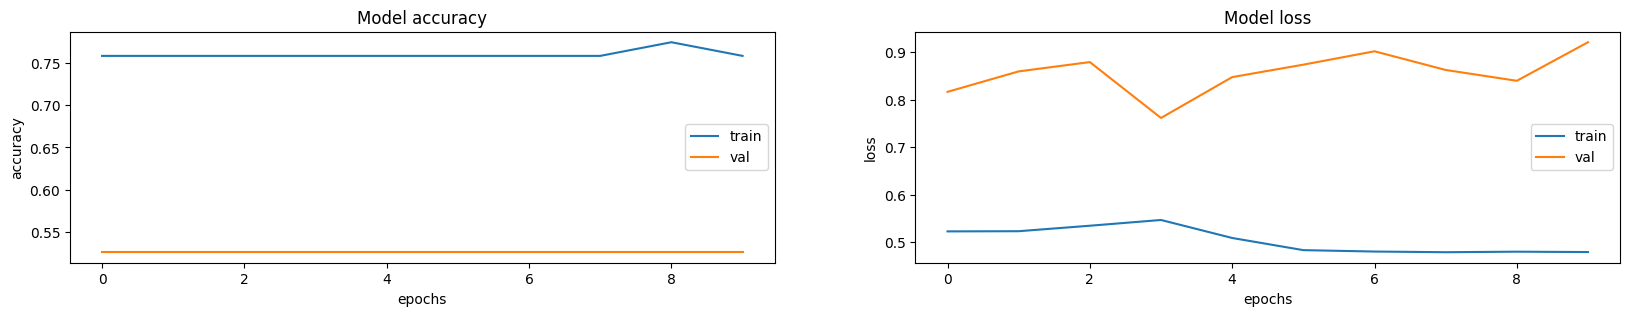

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
[[0.]]
The image belongs to class: abnormal


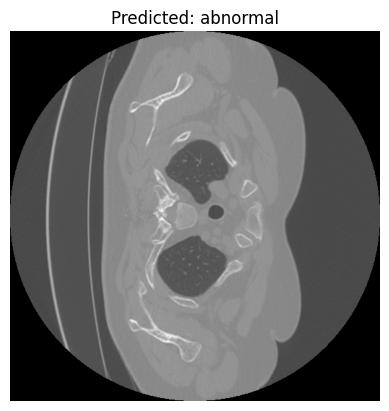

In [36]:
# Function to load and preprocess an image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np
import nibabel as nib
import os
from skimage.transform import resize

# Define a function to load and preprocess the image
def loading_and_preprocessing_image(image_path):
    """Loads and preprocesses a single image for prediction."""
    img = nib.load(image_path)  # Load the .nii.gz file
    img_data = img.get_fdata()  # Get the image data as numpy array
    # Resize the image to (64, 64, 64) - Adjust if needed
    img_data = resize(img_data, (64, 64, 64), order=3, preserve_range=True)
    # Add channel dimension
    img_data = np.expand_dims(img_data, axis=-1)
    # Add batch dimension
    img_data = np.expand_dims(img_data, axis=0)
    return img_data


# Load and preprocess a single image
image_path = '/content/drive/MyDrive/lungT/train/abnormal/study_0950.nii.gz'  # Example path
preprocessed_image = loading_and_preprocessing_image(image_path)

# Make a prediction
predictions = model.predict(preprocessed_image)
print(predictions)
predicted_class = np.argmax(predictions[0])  # Assuming binary classification

# Map the predicted class to the class label (if needed)
class_labels = {0: 'normal', 0: 'abnormal'}  # Replace with your actual labels
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

def display_nifti_slice(image_path, slice_index=32):  # Adjust slice_index as needed
    """Displays a slice of a NIfTI image."""
    img = nib.load(image_path)
    img_data = img.get_fdata()
    plt.imshow(img_data[:, :, slice_index], cmap='gray')  # Adjust cmap as needed
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()



# Display a slice of the NIfTI image
display_nifti_slice(image_path)